In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import csv
import os
import re
import nltk
import datetime
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import seaborn as sns
nltk.download('stopwords')
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
nltk.download("wordnet")
nltk.download('punkt')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import hamming_loss, f1_score, precision_score, accuracy_score, recall_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import VotingClassifier
np.set_printoptions(threshold=np.inf)
pd.set_option('display.max_columns', None)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy
from keras.layers import BatchNormalization
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification
from tensorflow.keras.optimizers import Adam


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
os.chdir(r'/content/drive/MyDrive/DataScience/Datasets/ToxicComments')
dataset = pd.read_csv('dataset.csv', quoting = csv.QUOTE_ALL)
codeStartTime = datetime.datetime.now()

## Part 1: Data and Feature-Engineering

In [9]:
lemmatizer = WordNetLemmatizer()

def lemmatize_word(word):
    pos = get_wordnet_pos(word)
    if pos:
        return lemmatizer.lemmatize(word, pos)
    else:
        return lemmatizer.lemmatize(word)

def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ, "N": wordnet.NOUN, "V": wordnet.VERB, "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

startTime = datetime.datetime.now()
corpus = []
for i in range(0, len(dataset)):
    comments = re.sub('[^a-zA-Z]', ' ', dataset['comment_text'][i])
    comments = re.sub(r'[!@#$%^&*(),.?":{}|<>]', ' ', comments)
    comments = re.sub(r'\d+', ' ', comments)
    comments = re.sub(r'http\S+|www.\S+', ' ', comments)
    comments = comments.lower()
    all_stopwords = stopwords.words('english')
    all_stopwords.remove('not')
    comments = comments.split()
    comments = [lemmatize_word(word) for word in comments if not word in set(all_stopwords)]
    comments = ' '.join(comments)
    corpus.append(comments)
endTime = datetime.datetime.now()
print(f'Total time taken to run code is {endTime - startTime}')

Total time taken to run code is 0:15:38.157865


In [10]:
inputArray = np.array(corpus)
targetArray = dataset.iloc[:, 2].values
dfPreProcessed = pd.DataFrame({'Input': inputArray, 'Target': targetArray})
dfPreProcessed.to_csv('dfPreProcessed', index=False, sep='|')

In [11]:
dataset2 = pd.read_csv('dfPreProcessed', sep = '|', quoting = csv.QUOTE_ALL)
dataset2 = dataset2.dropna()
dataset2 = dataset2
inputArray = np.array(dataset2.iloc[:, 0].values)
targetArray = np.array(dataset2.iloc[:, 1].values)
distinctWords = list(set(" ".join(inputArray).split()))

from collections import Counter

word_counts = Counter()

for line in inputArray:
    words = line.split()
    word_counts.update(words)

distinct_words_counts = dict(word_counts)
sorted_dict = {k: v for k, v in sorted(distinct_words_counts.items(), key=lambda item: item[1], reverse=True)}
sorted_dict

count_of_words_appeared_once = 0
for word, count in distinct_words_counts.items():
    if count == 1:
        count_of_words_appeared_once += 1
print(f'Count of words that appeared only once in corpus is: {count_of_words_appeared_once}')

Count of words that appeared only once in corpus is: 78665


In [12]:
startTime = datetime.datetime.now()
corpus = [' '.join(nltk.word_tokenize(sentence)) for sentence in inputArray.astype(str)]

tfidf_vectorizer = TfidfVectorizer(max_features = 1000)
X_tfidf = tfidf_vectorizer.fit_transform(corpus).toarray()
endTime = datetime.datetime.now()
print(f"Total Time taken to create TFIDF vector is: {endTime - startTime}")

Total Time taken to create TFIDF vector is: 0:00:49.479567


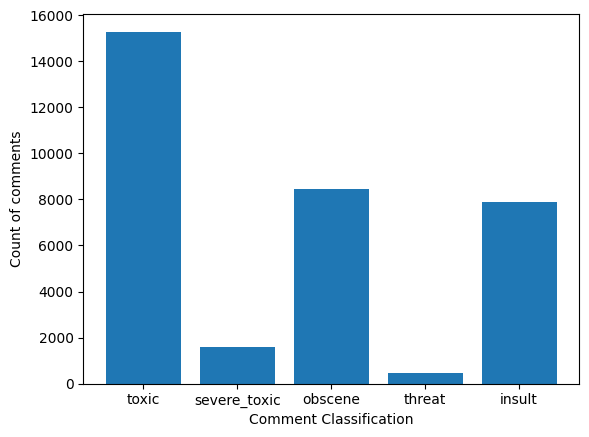

<Axes: >

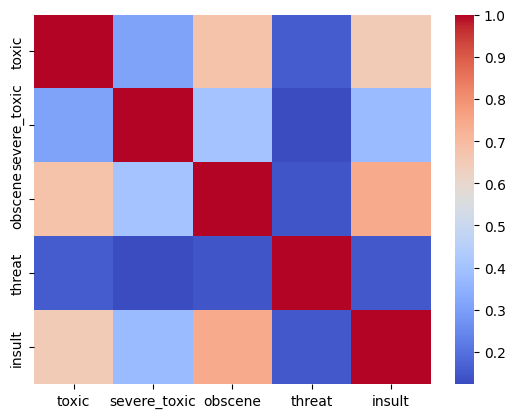

In [13]:
plt.bar(dataset.columns[2:-1], dataset.iloc[:, 2:-1].sum().values)
plt.xlabel('Comment Classification')
plt.ylabel('Count of comments')
plt.show()
import seaborn as sns
correlationMatrix = dataset.iloc[:, 2:-1].corr()
sns.heatmap(correlationMatrix, cmap = 'coolwarm')


## Part 2: Modeling and Evaluation

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, targetArray, test_size = 0.20, shuffle=False)

Accuracy score of Gaussian MNB model on train data is: 0.946
Accuracy score of Gaussian MNB model model on test data is: 0.946
F1 score of MNB model on test data is is: 0.6138437569552637
              precision    recall  f1-score   support

           0       0.95      1.00      0.97     28867
           1       0.95      0.45      0.61      3037

    accuracy                           0.95     31904
   macro avg       0.95      0.73      0.79     31904
weighted avg       0.95      0.95      0.94     31904



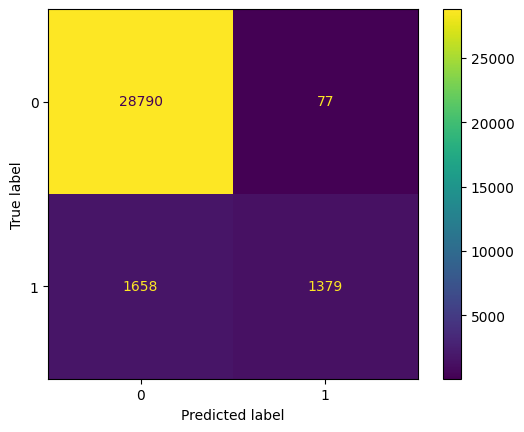

In [15]:
classifierMNB = MultinomialNB()
classifierMNB.fit(X_train, y_train)
y_PredTestMNB = classifierMNB.predict(X_test)
y_PredTrainMNB = classifierMNB.predict(X_train)
acTrainMNB = accuracy_score(y_train, y_PredTrainMNB)
print("Accuracy score of Gaussian MNB model on train data is:", round(acTrainMNB, 3))
acTestMNB = accuracy_score(y_test, y_PredTestMNB)
print("Accuracy score of Gaussian MNB model model on test data is:", round(acTestMNB,3))
cmMNB = confusion_matrix(y_test, y_PredTestMNB)
f1_scoreMNB = f1_score(y_test, y_PredTestMNB)
print("F1 score of MNB model on test data is is:", f1_scoreMNB)
print(classification_report(y_test, y_PredTestMNB))
ConfusionMatrixDisplay(cmMNB).plot()

Accuracy score of logistic regression model on train data is : 0.951
Accuracy score of logistic regression model on test data is : 0.95
F1 score for logistic regression model on test data is : 0.714
              precision    recall  f1-score   support

           0       0.96      0.98      0.97     28867
           1       0.78      0.66      0.71      3037

    accuracy                           0.95     31904
   macro avg       0.87      0.82      0.84     31904
weighted avg       0.95      0.95      0.95     31904



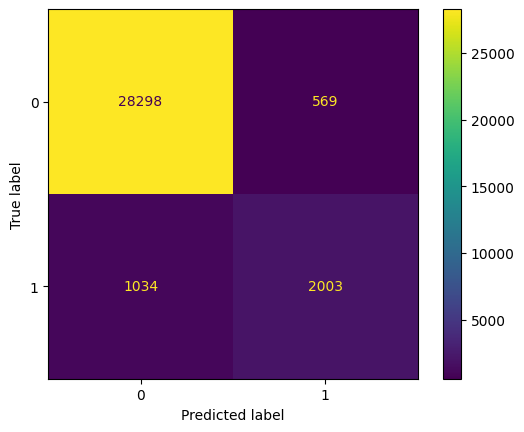

In [16]:
class_weights = {0: 1, 1: 2}
logClassifier = LogisticRegression(penalty = "l1", solver = "liblinear", C = 10, class_weight = class_weights)
logClassifier.fit(X_train, y_train)

acTrainLog = accuracy_score(y_train, logClassifier.predict(X_train))
print("Accuracy score of logistic regression model on train data is :", round(acTrainLog, 3))
y_TestLogPred = logClassifier.predict(X_test)
acTestLog = accuracy_score(y_test, y_TestLogPred)
print("Accuracy score of logistic regression model on test data is :", round(acTestLog, 3))
cmLog = confusion_matrix(y_test, y_TestLogPred)
logF1_score = f1_score(y_test, y_TestLogPred)
print("F1 score for logistic regression model on test data is :", round(logF1_score, 3))
print(classification_report(y_test, y_TestLogPred))
ConfusionMatrixDisplay(cmLog).plot()

Accuracy score of Linear Support Vector classifier model on test data is: 0.952
F1 score on test data is: 0.692
              precision    recall  f1-score   support

           0       0.96      0.99      0.97     28867
           1       0.89      0.57      0.69      3037

    accuracy                           0.95     31904
   macro avg       0.92      0.78      0.83     31904
weighted avg       0.95      0.95      0.95     31904

Total time taken to run Linear SVC code is 0:00:01.827327


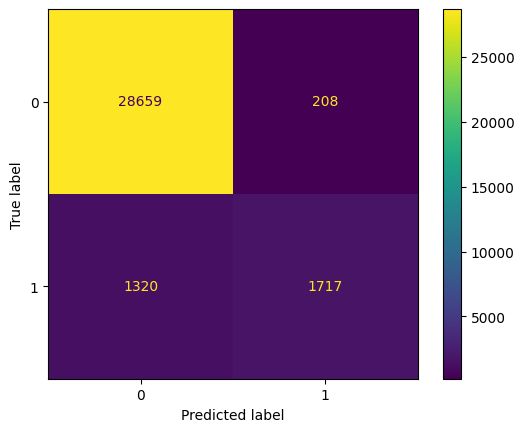

In [17]:

startTime = datetime.datetime.now()
class_weights = {0: 1, 1: 1}
linearSVMClassifier = LinearSVC(class_weight=class_weights, max_iter = 3000)
linearSVMClassifier.fit(X_train, y_train)
y_TestLinearSVMPred = linearSVMClassifier.predict(X_test)
acTestLinearSVM = round(accuracy_score(y_test, y_TestLinearSVMPred), 3)
print("Accuracy score of Linear Support Vector classifier model on test data is:", acTestLinearSVM)
cmLinearSVM = confusion_matrix(y_test, y_TestLinearSVMPred)
svmF1_score = round(f1_score(y_test, y_TestLinearSVMPred), 3)
print("F1 score on test data is:", svmF1_score)
print(classification_report(y_test, y_TestLinearSVMPred))
ConfusionMatrixDisplay(cmLinearSVM).plot()
endTime = datetime.datetime.now()
print(f'Total time taken to run Linear SVC code is {endTime - startTime}')

Accuracy score of Ensemble  classifier model on train data is: 0.953
Accuracy score of Ensemble classifier model on test data is: 0.952
F1 score on test data is: 0.695
              precision    recall  f1-score   support

           0       0.96      0.99      0.97     28867
           1       0.89      0.57      0.69      3037

    accuracy                           0.95     31904
   macro avg       0.92      0.78      0.83     31904
weighted avg       0.95      0.95      0.95     31904



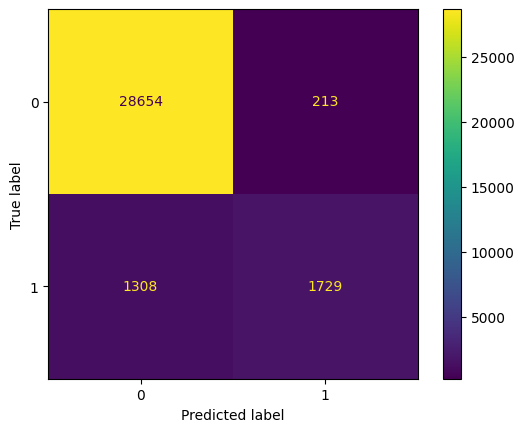

In [18]:
ensembleClassifier = VotingClassifier(estimators = [('MNB', classifierMNB), ('SVC', linearSVMClassifier), ('LR', logClassifier)], voting = 'hard')
ensembleClassifier.fit(X_train, y_train)
acEnsemble = round(accuracy_score(y_train, ensembleClassifier.predict(X_train)), 3)
print("Accuracy score of Ensemble  classifier model on train data is:", acEnsemble)
y_TestEnsemblePred = ensembleClassifier.predict(X_test)
acTestEnsemble = round(accuracy_score(y_test, y_TestEnsemblePred), 3)
print("Accuracy score of Ensemble classifier model on test data is:", acTestEnsemble)
cmEnsemble = confusion_matrix(y_test, y_TestEnsemblePred)
ensembleF1_score = round(f1_score(y_test, y_TestEnsemblePred), 3)
print("F1 score on test data is:", ensembleF1_score)
ConfusionMatrixDisplay(cmEnsemble).plot()
print(classification_report(y_test, y_TestEnsemblePred))



In [22]:
textString1 = "you bloody bastard go to hell"
textString2 = "He is a good person"
textString3 = "You are not a bastard I am sorry"
textString4 = "I am sorry for calling you a retard"
textString5 = "You are a retard"
textString6 = "You are not at all a good person"
inputList = [textString1, textString2, textString3, textString4, textString5, textString6]
textArray =  np.array(inputList)
sampleText = tfidf_vectorizer.transform(textArray).toarray()

In [23]:
predictions = ensembleClassifier.predict(sampleText)
results = list(zip(inputList, predictions))

for text, prediction in results:
    print(f"Text: {text} Prediction: {prediction}     Here 0 means 'not-toxic' and 1 implies 'toxic'")

Text: you bloody bastard go to hell Prediction: 1     Here 0 means 'not-toxic' and 1 implies 'toxic'
Text: He is a good person Prediction: 0     Here 0 means 'not-toxic' and 1 implies 'toxic'
Text: You are not a bastard I am sorry Prediction: 0     Here 0 means 'not-toxic' and 1 implies 'toxic'
Text: I am sorry for calling you a retard Prediction: 0     Here 0 means 'not-toxic' and 1 implies 'toxic'
Text: You are a retard Prediction: 0     Here 0 means 'not-toxic' and 1 implies 'toxic'
Text: You are not at all a good person Prediction: 0     Here 0 means 'not-toxic' and 1 implies 'toxic'


Text(0.5, 1.0, 'Model Accuracies')

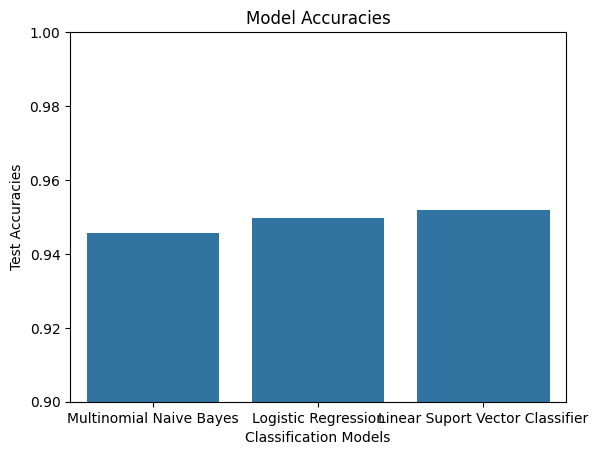

In [24]:
import seaborn as sns
classModels = ['Multinomial Naive Bayes', 'Logistic Regression', 'Linear Suport Vector Classifier']
accuracyTest = [acTestMNB, acTestLog, acTestLinearSVM]
ax = sns.barplot(x= classModels,y = accuracyTest)
ax.set(ylim = (0.9, 1))
plt.xlabel("Classification Models")
plt.ylabel("Test Accuracies")
plt.title("Model Accuracies")

## Part 3: (LSTM)

In [25]:
texts = inputArray
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
X_padded = pad_sequences(sequences, maxlen=10, padding='post', truncating='post')


X_train, X_rem, y_train, y_rem = train_test_split(X_padded, targetArray, test_size=0.2, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_rem, y_rem, test_size=0.5, shuffle=False)

model = Sequential()
model.add(Embedding(10000 + 1, 16))
model.add(Bidirectional(LSTM(16, activation='tanh')))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [26]:
model.compile(loss='BinaryCrossentropy', optimizer='Adam')
model.summary()

startTime = datetime.datetime.now()

class_weight_dict = {0: 1, 1: 2}

history = model.fit(X_train, y_train, epochs=3, validation_data=(X_val, y_val), class_weight=class_weight_dict)

endTime = datetime.datetime.now()
print(f'Total time taken to perform LSTM fit is {endTime - startTime}')

pre = Precision()
re = Recall()
acc = CategoricalAccuracy()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160016    
                                                                 
 bidirectional (Bidirection  (None, 32)                4224      
 al)                                                             
                                                                 
 batch_normalization (Batch  (None, 32)                128       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 256)               8448      
                                                                 
 batch_normalization_1 (Bat  (None, 256)               1

1/1 [==============================] - 0s 43ms/step
Text: you bloody bastard go to hell, Probability: 0.9953787326812744
Text: He is a good person, Probability: 0.19167199730873108
Text: You are not a bastard I am sorry, Probability: 0.9484031796455383
Text: I am sorry for calling you a retard, Probability: 0.8729763627052307
Text: You are a retard, Probability: 0.944897472858429
Text: You are not at all a good person, Probability: 0.08285404741764069
499/499 [==============================] - 2s 5ms/step
              precision    recall  f1-score   support

           0       0.97      0.98      0.97     14409
           1       0.79      0.68      0.73      1543

    accuracy                           0.95     15952
   macro avg       0.88      0.83      0.85     15952
weighted avg       0.95      0.95      0.95     15952



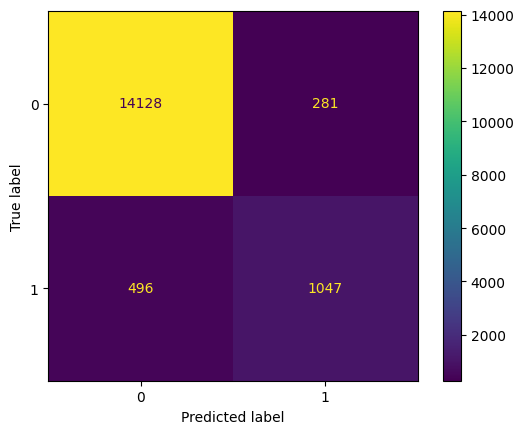

In [29]:
sampleText = tokenizer.texts_to_sequences(textArray)
sampleText = pad_sequences(sampleText, maxlen=10, padding='post', truncating='post')

predictions = model.predict(sampleText)
results = list(zip(textArray, predictions.flatten()))
for text, prediction in results:
    print(f"Text: {text}, Probability: {prediction}")

y_predTest = model.predict(X_test)
y_predClass = (y_predTest >= 0.5).astype(int)

cm = confusion_matrix(y_test, y_predClass)
ConfusionMatrixDisplay(cm).plot()
classReport = classification_report(y_test, y_predClass)
print(classReport)

In [28]:
model.save('lstm_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
codeEndTime = datetime.datetime.now()
print(f'Total time taken to run the whole code is {codeEndTime - codeStartTime}')

Total time taken to run the whole code is 0:10:31.813284



#BERT Model



In [30]:
X_train, X_rem, y_train, y_rem = train_test_split(inputArray, targetArray, test_size=0.2, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_rem, y_rem, test_size=0.5, shuffle=False)

X_trainBert, X_valBert, X_testBert = X_train.tolist(), X_val.tolist(), X_test.tolist()
y_trainBert, y_valBert, y_testBert = y_train, y_val, y_test

# model_name = "bert-base-uncased"
model_name = "prajjwal1/bert-small"
# num_hidden_layers = 3
tokenizer = BertTokenizer.from_pretrained(model_name)
bert_model = TFBertForSequenceClassification.from_pretrained(model_name, from_pt=True)

encoded_data = tokenizer(
    X_trainBert,
    add_special_tokens=True,
    max_length=32,
    padding='max_length',
    truncation=True,
    return_attention_mask=True,
    return_tensors='tf'
)



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/286 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/116M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForSequenceClassification: ['bert.embeddings.position_ids']
- This IS expected if you are initializing TFBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [31]:
optimizer = Adam(learning_rate=2e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = ['accuracy']
tf.config.run_functions_eagerly(True)
bert_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

encoded_val_data = tokenizer(
    X_valBert,
    add_special_tokens=True,
    max_length=32,
    padding='max_length',
    truncation=True,
    return_attention_mask=True,
    return_tensors='tf'
)

encoded_val_data_dict = {key: np.array(value) for key, value in encoded_val_data.items()}


encoded_data_dict = {key: np.array(value) for key, value in encoded_data.items()}
X_valBert_encoded = {key: np.array(value) for key, value in encoded_data.items()}
history = bert_model.fit(
    encoded_data_dict,
    y_trainBert,
    validation_data=(encoded_val_data_dict, y_valBert),
    epochs=2,
    batch_size=256
)

encoded_test_data = tokenizer(
    X_testBert,
    add_special_tokens=True,
    max_length=32,
    padding='max_length',
    truncation=True,
    return_attention_mask=True,
    return_tensors='tf'
)

encoded_test_data_dict = {key: np.array(value) for key, value in encoded_test_data.items()}

test_loss, test_accuracy = bert_model.evaluate(
    encoded_test_data_dict,
    y_testBert
)

print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

Epoch 1/2


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


499/499 [==============================] - 289s 575ms/step - loss: 0.1492 - accuracy: 0.9466 - val_loss: 0.1109 - val_accuracy: 0.9607
Epoch 2/2
499/499 [==============================] - 46s 91ms/step - loss: 0.1102 - accuracy: 0.9591
Test Loss: 0.11019210517406464
Test Accuracy: 0.9591273665428162


In [34]:
# Example text strings
# text_strings = [
#     "you bloody bastard go to hell",
#     "He is a good person",
#     "You are not a bastard I am sorry",
#     "I am sorry for calling you a retard",
#     "You are a retard"
# ]
encoded_strings = tokenizer(
    inputList,
    add_special_tokens=True,
    max_length=64,
    padding='max_length',
    truncation=True,
    return_attention_mask=True,
    return_tensors='tf'
)

encoded_strings_dict = {key: np.array(value) for key, value in encoded_strings.items()}

predictions = bert_model.predict(encoded_strings_dict)

logits = predictions.logits

probabilities = tf.nn.softmax(logits, axis=-1)

for i, text in enumerate(inputList):
    print(f"Text: {text}")
    print(f"Predicted Probabilities: {probabilities[i]}")
    print()

1/1 [==============================] - 0s 128ms/step


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Text: you bloody bastard go to hell
Predicted Probabilities: [0.00412635 0.99587363]

Text: He is a good person
Predicted Probabilities: [0.9782904  0.02170964]

Text: You are not a bastard I am sorry
Predicted Probabilities: [0.04086864 0.95913136]

Text: I am sorry for calling you a retard
Predicted Probabilities: [0.10238495 0.897615  ]

Text: You are a retard
Predicted Probabilities: [0.0712809 0.9287191]

Text: You are not at all a good person
Predicted Probabilities: [0.9509756  0.04902444]



## That's All

References:
    
    https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html
    https://www.youtube.com/watch?v=ZUqB-luawZg
    https://medium.com/analytics-vidhya/getting-started-with-nlp-tokenization-document-term-matrix-tf-idf-2ea7d01f1942
    https://www.nltk.org/api/nltk.tag.pos_tag.html
    https://www.nltk.org/_modules/nltk/stem/wordnet.html
    https://www.geeksforgeeks.org/python-lemmatization-with-nltk/
    https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM
    https://datascience.stackexchange.com/questions/72296/predict-proba-for-binary-classifier-in-tensorflow